In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import json

class PortfolioSimulation:
    def __init__(self, initial_prices, weights, expected_returns, volatilities, correlations, 
                 initial_investment=10000, num_simulations=1000, time_horizon=252):
        """Initialize the Portfolio Simulation with key parameters"""
        self.initial_prices = np.array(initial_prices)
        self.weights = np.array(weights)
        self.expected_returns = np.array(expected_returns)
        self.volatilities = np.array(volatilities)
        self.correlations = correlations
        self.initial_investment = initial_investment
        self.num_simulations = num_simulations
        self.time_horizon = time_horizon
        self.shares = (self.weights * self.initial_investment) / self.initial_prices

    def generate_price_paths(self):
        """Generate Monte Carlo simulated price paths for the assets"""
        daily_returns = self.expected_returns / 252
        daily_volatilities = self.volatilities / np.sqrt(252)
        L = np.linalg.cholesky(self.correlations)
        
        all_prices = np.zeros((self.num_simulations, self.time_horizon + 1, len(self.initial_prices)))
        all_prices[:, 0] = self.initial_prices
        
        for sim in range(self.num_simulations):
            correlated_rand = np.dot(
                np.random.standard_normal((self.time_horizon, len(self.initial_prices))), 
                L.T
            )
            
            for t in range(1, self.time_horizon + 1):
                all_prices[sim, t] = all_prices[sim, t-1] * np.exp(
                    daily_returns - 0.5 * daily_volatilities**2 + 
                    daily_volatilities * correlated_rand[t-1]
                )
                
        return all_prices

    def calculate_portfolio_values(self, price_paths):
        """Calculate portfolio values for each simulation and time step"""
        return np.sum(price_paths * self.shares, axis=2)

    def calculate_var(self, portfolio_values, confidence_level=0.95):
        """Calculate Value at Risk (VaR) at a given confidence level"""
        final_values = portfolio_values[:, -1]
        returns = (final_values - self.initial_investment) / self.initial_investment
        return np.percentile(returns, (1 - confidence_level) * 100)

    def numpy_to_python(self, obj):
        """Convert numpy types to Python native types for JSON serialization"""
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                             np.int16, np.int32, np.int64, np.uint8,
                             np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return obj

    def generate_simulation_data(self):
        """Generate complete simulation data including price paths and statistics"""
        # Generate price paths
        price_paths = self.generate_price_paths()
        portfolio_values = self.calculate_portfolio_values(price_paths)
        
        # Calculate statistics
        final_values = portfolio_values[:, -1]
        returns = (final_values - self.initial_investment) / self.initial_investment
        var_95 = np.percentile(returns, 5)
        var_99 = np.percentile(returns, 1)
        expected_return = np.mean(returns)
        volatility = np.std(returns)
        
        simulation_data = {
            "simulation_parameters": {
                "initial_investment": self.numpy_to_python(self.initial_investment),
                "time_horizon_days": self.numpy_to_python(self.time_horizon),
                "num_simulations": self.numpy_to_python(self.num_simulations),
                "num_assets": len(self.initial_prices)
            },
            "portfolio_composition": [
                {
                    "asset_id": i + 1,
                    "weight": self.numpy_to_python(self.weights[i]),
                    "initial_price": self.numpy_to_python(self.initial_prices[i]),
                    "expected_annual_return": self.numpy_to_python(self.expected_returns[i]),
                    "annual_volatility": self.numpy_to_python(self.volatilities[i]),
                    "number_of_shares": self.numpy_to_python(self.shares[i])
                }
                for i in range(len(self.initial_prices))
            ],
            "risk_metrics": {
                "value_at_risk_95": self.numpy_to_python(var_95),
                "value_at_risk_99": self.numpy_to_python(var_99),
                "expected_annual_return": self.numpy_to_python(expected_return),
                "portfolio_volatility": self.numpy_to_python(volatility),
                "sharpe_ratio": self.numpy_to_python((expected_return - 0.02) / volatility)
            },
            "final_value_statistics": {
                "mean": self.numpy_to_python(np.mean(final_values)),
                "median": self.numpy_to_python(np.median(final_values)),
                "minimum": self.numpy_to_python(np.min(final_values)),
                "maximum": self.numpy_to_python(np.max(final_values)),
                "standard_deviation": self.numpy_to_python(np.std(final_values)),
                "probability_of_profit": self.numpy_to_python(np.mean(final_values > self.initial_investment))
            },
            "price_paths": {
                "timestamps": list(range(self.time_horizon + 1)),
                "portfolio_values": {
                    f"simulation_{i+1}": self.numpy_to_python(portfolio_values[i])
                    for i in range(min(10, self.num_simulations))  # Store first 10 simulations
                },
                "mean_path": self.numpy_to_python(np.mean(portfolio_values, axis=0))
            }
        }
        
        return simulation_data

    def save_simulation_data(self, filename="monte_carlo_simulation.json"):
        """Run simulation and save results to JSON file"""
        simulation_data = self.generate_simulation_data()
        
        with open(filename, 'w') as f:
            json.dump(simulation_data, f, indent=2)
        
        print(f"Simulation data saved to {filename}")
        return simulation_data
    
    
    def optimize_weights(self):
        """
        Optimize the portfolio weights to minimize portfolio volatility 
        while maintaining full investment (sum of weights = 1).
        """
        # Calculate covariance matrix from volatilities and correlations
        cov_matrix = np.outer(self.volatilities, self.volatilities) * self.correlations
        
        # Initial weights (start equally distributed)
        initial_weights = np.array(self.weights)
        
        # Define objective function (volatility) and constraints
        def portfolio_volatility(weights):
            weights = np.array(weights)
            portfolio_var = np.dot(weights.T, np.dot(cov_matrix, weights))
            return np.sqrt(portfolio_var)
        
        def portfolio_return(weights):
            return np.dot(weights, self.expected_returns)
        
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Sum of weights = 1
        bounds = tuple((0, 1) for _ in initial_weights)  # Weights between 0 and 1

        # Perform optimization
        optimized = minimise(portfolio_volatility, initial_weights, bounds=bounds, constraints=constraints)
        optimized_weights = optimized.x
        
        # Update weights in the simulation object
        self.weights = optimized_weights
        
        # Print results
        print("Optimized Weights:", optimized_weights)
        print("Portfolio Volatility (Minimized):", portfolio_volatility(optimized_weights))
        print("Portfolio Expected Return:", portfolio_return(optimized_weights))
        
        return optimized_weights

    def print_summary(self, results):
        """Print a comprehensive summary of simulation results"""
        print("\n=== MONTE CARLO SIMULATION SUMMARY ===")
        print("\nSimulation Parameters:")
        print(f"Initial Investment: ${self.initial_investment:,.2f}")
        print(f"Time Horizon: {self.time_horizon} trading days (≈ 1 year)")
        print(f"Number of Simulations: {self.num_simulations}")
        print(f"Number of Assets: {len(self.initial_prices)}")
        
        print("\nPortfolio Composition:")
        for i, (weight, price, ret, vol) in enumerate(zip(self.weights, self.initial_prices, 
                                                          self.expected_returns, self.volatilities)):
            print(f"Asset {i+1}:")
            print(f"  - Weight: {weight*100:.1f}%")
            print(f"  - Initial Price: ${price:.2f}")
            print(f"  - Expected Annual Return: {ret*100:.1f}%")
            print(f"  - Annual Volatility: {vol*100:.1f}%")
        
        print("\nRisk Metrics:")
        print(f"Value at Risk (95% confidence): {results['VaR_95']*100:.1f}%")
        print(f"Value at Risk (99% confidence): {results['VaR_99']*100:.1f}%")
        print(f"Expected Annual Return: {results['Expected_Return']*100:.1f}%")
        print(f"Portfolio Volatility: {results['Volatility']*100:.1f}%")
        
        final_values = results['Final_Values']
        print("\nFinal Portfolio Value Statistics:")
        print(f"Mean: ${np.mean(final_values):,.2f}")
        print(f"Median: ${np.median(final_values):,.2f}")
        print(f"Minimum: ${np.min(final_values):,.2f}")
        print(f"Maximum: ${np.max(final_values):,.2f}")
        print(f"Std Dev: ${np.std(final_values):,.2f}")
        
        profit_prob = np.mean(final_values > self.initial_investment)
        print(f"\nProbability of Profit: {profit_prob*100:.1f}%")
        
        # Calculate Sharpe Ratio (assuming risk-free rate of 2%)
        risk_free_rate = 0.02
        sharpe_ratio = (results['Expected_Return'] - risk_free_rate) / results['Volatility']
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        
    def run_simulation(self):
        """Run simulation, plot results, and print a comprehensive summary"""
        # Generate price paths
        price_paths = self.generate_price_paths()
        portfolio_values = self.calculate_portfolio_values(price_paths)
        
        # Calculate metrics
        var_95 = self.calculate_var(portfolio_values, 0.95)
        var_99 = self.calculate_var(portfolio_values, 0.99)
        final_values = portfolio_values[:, -1]
        expected_return = (np.mean(final_values) - self.initial_investment) / self.initial_investment
        volatility = np.std(final_values) / self.initial_investment
        
        results = {
            'VaR_95': var_95,
            'VaR_99': var_99,
            'Expected_Return': expected_return,
            'Volatility': volatility,
            'Final_Values': final_values
        }
        
        # Plot results
        plt.figure(figsize=(12, 6))
        for i in range(min(100, self.num_simulations)):
            plt.plot(portfolio_values[i], alpha=0.1, color='blue')
        mean_path = np.mean(portfolio_values, axis=0)
        plt.plot(mean_path, color='red', linewidth=2, label='Mean Path')
        
        plt.title('Monte Carlo Simulation of Portfolio Value')
        plt.xlabel('Time (days)')
        plt.ylabel('Portfolio Value ($)')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Print comprehensive summary
        self.print_summary(results)
        
        return results


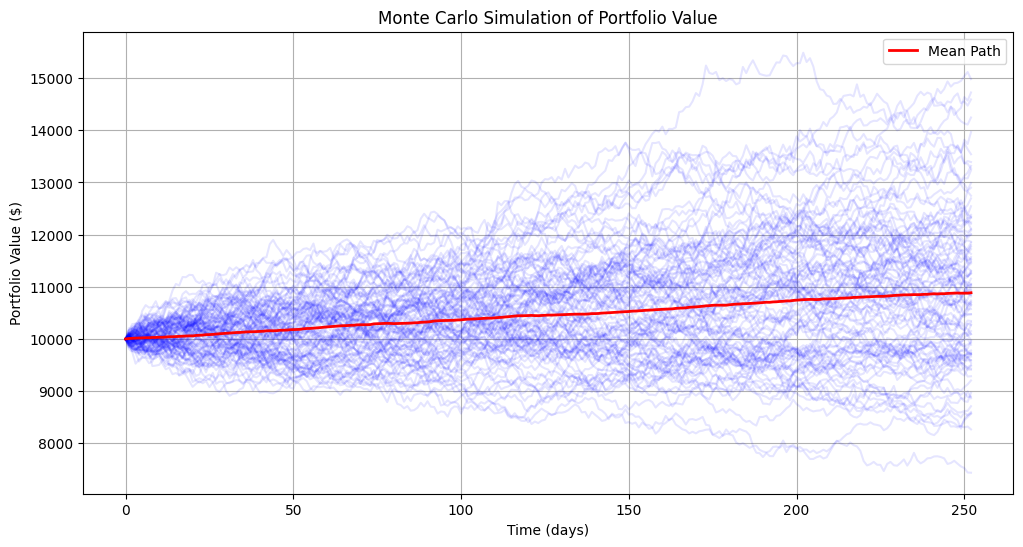


=== MONTE CARLO SIMULATION SUMMARY ===

Simulation Parameters:
Initial Investment: $10,000.00
Time Horizon: 252 trading days (≈ 1 year)
Number of Simulations: 1000
Number of Assets: 3

Portfolio Composition:
Asset 1:
  - Weight: 28.5%
  - Initial Price: $100.00
  - Expected Annual Return: 10.0%
  - Annual Volatility: 20.0%
Asset 2:
  - Weight: 62.3%
  - Initial Price: $50.00
  - Expected Annual Return: 8.0%
  - Annual Volatility: 15.0%
Asset 3:
  - Weight: 9.2%
  - Initial Price: $75.00
  - Expected Annual Return: 12.0%
  - Annual Volatility: 25.0%

Risk Metrics:
Value at Risk (95% confidence): -12.1%
Value at Risk (99% confidence): -21.7%
Expected Annual Return: 8.9%
Portfolio Volatility: 14.4%

Final Portfolio Value Statistics:
Mean: $10,885.89
Median: $10,848.58
Minimum: $7,272.40
Maximum: $17,938.66
Std Dev: $1,443.92

Probability of Profit: 71.0%
Sharpe Ratio: 0.48
Optimized Weights: [0.28527365 0.62314032 0.09158603]
Portfolio Volatility (Minimized): 0.13398051497048763
Portfoli

In [27]:
# Example usage
initial_prices = [100, 50, 75]
weights = [0.28527365,0.62314032,0.09158603]
expected_returns = [0.10, 0.08, 0.12]
volatilities = [0.20, 0.15, 0.25]
correlations = np.array([
    [1.0, 0.3, 0.2],
    [0.3, 1.0, 0.4],
    [0.2, 0.4, 1.0]
])

# Initialize the simulation
sim = PortfolioSimulation(
    initial_prices=initial_prices,
    weights=weights,
    expected_returns=expected_returns,
    volatilities=volatilities,
    correlations=correlations,
    initial_investment=10000,
    num_simulations=1000,
    time_horizon=252
)

# Run the simulation and display results
results = sim.run_simulation()  # This method generates the plot and prints the summary

# Optimize weights
optimized_weights = sim.optimize_weights()
# Save simulation data to JSON file
simulation_data = sim.save_simulation_data()

